# AI Tool for Actuaries
## Chapter 9: Explainability
## Authors: Michael Mayer and Mario Wuthrich
## Version June 2025


This Jupyter notebook uses typical explainability tools to inspect both a GLM with a regression spline and the boosted trees model of Chapter 7.

We use three packages for explainability:

- Scikit-Learn with its inspection module
- {model-diagnostics} of Christian Lorentzen
- {shap}

Methods not available in these packages are provided as separate Python scripts "hstats.py" and "ale.py".

Parts of the code are adapted from the [lecture notes](https://github.com/lorentzenchr/responsible_ml_material) of the ETH lecture "Responsible ML with insurance applications".

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from lightgbm import LGBMRegressor
from model_diagnostics.calibration import plot_marginal
from sklearn import tree
from sklearn.base import RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_poisson_deviance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, SplineTransformer
from sklearn.tree import DecisionTreeRegressor


## Load and pre-process data as in Chapter 7

In [2]:
# Load and inspect the data (this dataset contains counts and severities)
df = pd.read_parquet("../../Data/freMTPL2freq.parquet")
df.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


In [3]:
# Preprocessing of features mainly to improve interpretability
df1 = df.assign(
    frequency=lambda x: x.ClaimNb / x.Exposure,
    severity=lambda x: (x.ClaimTotal / x.ClaimNb).clip(0, 5e4),
    VehAge=lambda x: x.VehAge.clip(0, 25),  # censoring at 25 years
    lDensity=lambda x: np.log(
        x.Density
    ),  # log-transform is not needed for GBM, but it improves visualization in SHAP
    Region=lambda x: x.Region.cat.set_categories(  # keep only biggest levels
        ["R11", "R24", "R52", "R53", "R82", "R93", "Other"]
    ).fillna("Other"),
    VehBrand=lambda x: x.VehBrand.cat.set_categories(  # keep only biggest levels
        ["B1", "B2", "B3", "B5", "B12", "Other"]
    ).fillna("Other"),
)

## Modeling Claim Frequencies

Let's use Scikit-Learn's `PoissonRegressor()` to fit a GLM, and LightGBM to fit a boosted trees models. Note that the construction of the LightGBM is as in Chapter 7. 

In [4]:
# learning and test sample split (identical to Wuthrich-Merz, Springer 2023)
learn = df1[df1.LearnTest == "L"]
test = df1[df1.LearnTest == "T"]

print("Data shapes:", learn.shape, test.shape)

Data shapes: (610206, 17) (67801, 17)


### GLM with a regression spline for driver's age

In [5]:
features = ["DrivAge", "lDensity", "VehAge", "VehPower", "Region", "VehBrand", "VehGas"]

In [6]:
ohe = OneHotEncoder(drop=["R11", "B1", "Diesel"], sparse_output=False)
spline = SplineTransformer(
    n_knots=4, include_bias=False, knots="quantile", extrapolation="linear"
)

preprocess_glm = ColumnTransformer(
    transformers=[
        ("spline", spline, ["DrivAge"]),
        ("linear", "passthrough", ["lDensity", "VehAge", "VehPower"]),
        ("dummy", ohe, ["Region", "VehBrand", "VehGas"]),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

glm_freq = Pipeline(
    steps=[
        ("prep", preprocess_glm),
        ("glm", PoissonRegressor(solver="newton-cholesky", alpha=0, tol=1e-7)),
    ]
)
glm_freq.fit(learn, learn.frequency, glm__sample_weight=learn.Exposure)

print("Coefficients")
pd.Series(glm_freq[-1].coef_, index=glm_freq[0].get_feature_names_out())


Coefficients


DrivAge_sp_0      2.611669
DrivAge_sp_1     -9.269983
DrivAge_sp_2     -8.845485
DrivAge_sp_3     -8.831488
DrivAge_sp_4     -9.997389
lDensity          0.101666
VehAge           -0.012832
VehPower          0.024436
Region_Other      0.001388
Region_R24       -0.036761
Region_R52       -0.006126
Region_R53       -0.056952
Region_R82        0.181819
Region_R93        0.091698
VehBrand_B12     -0.247547
VehBrand_B2       0.008401
VehBrand_B3       0.058587
VehBrand_B5       0.123736
VehBrand_Other    0.037499
VehGas_Regular   -0.175676
dtype: float64

### Boosted trees model fitted by LightGBM

Hyper-parameters have been tuned by 5 fold cross-validation, using early stopping to determine a healthy amount of boosting rounds.

In [7]:
# Select covariates and turn categories to numbers
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", ["DrivAge", "lDensity", "VehAge", "VehPower"]),
        ("cat", OrdinalEncoder(), ["Region", "VehBrand", "VehGas"]),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Unordered categorical features
unordered = ["Region", "VehBrand"]

In [8]:
# Parameters found by randomized search five-fold CV on the training data,
# using early stopping to determine the number of rounds (not shown for brevity)
params_freq = {
    "objective": "poisson",
    "learning_rate": 0.02,
    "num_leaves": 15,
    "reg_lambda": 7.5,
    "reg_alpha": 4,
    "colsample_bynode": 1,
    "subsample": 1,
    "min_child_samples": 100,
    "min_split_gain": 0.01,
    "poisson_max_delta_step": 0.7,
}
nrounds_freq = 738

# We use the Scikit-Learn API of LightGBM
lgb_freq = LGBMRegressor(
    **params_freq, n_estimators=nrounds_freq, importance_type="gain", random_state=5
)
lgb_freq = Pipeline([("preprocessor", preprocess_tree), ("model", lgb_freq)])

# Fit model
_ = lgb_freq.fit(
    X=learn,
    y=learn.frequency,
    model__sample_weight=learn.Exposure,
    model__categorical_feature=unordered,
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 610206, number of used features: 7
[LightGBM] [Info] Start training from score -2.608692


## Performance

For this dataset and the selected features, the test performance measured by mean Poisson deviance is almost identical. This (possibly) means that the GLM is well specified and there are no strong interactions.

In [9]:
dummy_freq = DummyRegressor().fit(
    learn, y=learn.frequency, sample_weight=learn.Exposure
)

In [10]:
print("100 * Mean Poisson Deviance:")
for model, label in zip((dummy_freq, glm_freq, lgb_freq), ("Dummy", "GLM", "LightGBM")):
    value = 100 * mean_poisson_deviance(
        test.frequency, model.predict(test), sample_weight=test.Exposure
    )
    print(f" - {label}: {value:.2f}")

100 * Mean Poisson Deviance:
 - Dummy: 47.97
 - GLM: 46.95
 - LightGBM: 46.88


## Variable Importance

To get an impression on which features are important (or unimportant), we will first consider the tree-specific split gain importance introduced in Chapter 7. Then, we compare it with permutation importance calculated on the test data. 

### Split gain for LightGBM model

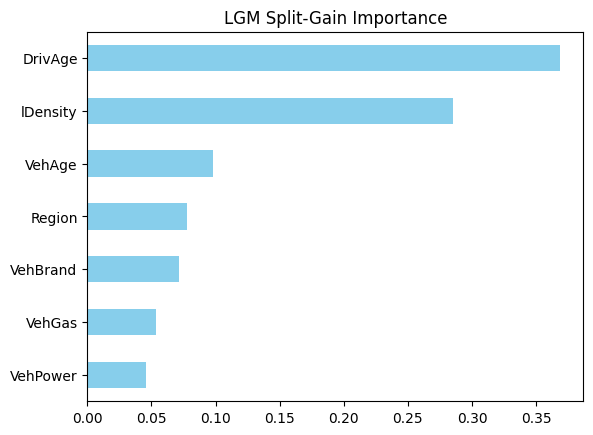

In [11]:
importance_values = lgb_freq[-1].feature_importances_
importance_values /= importance_values.sum()

importance_df = pd.Series(
    importance_values,
    index=lgb_freq[-1].feature_name_,
)

_ = importance_df.sort_values().plot.barh(
    color="skyblue", title="LGM Split-Gain Importance"
)

### Permutation importance for both models

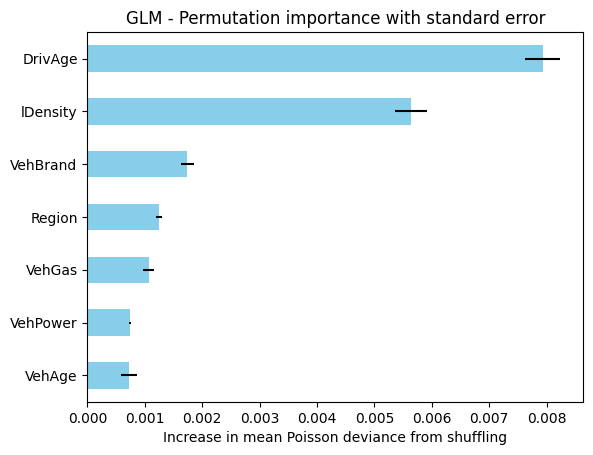

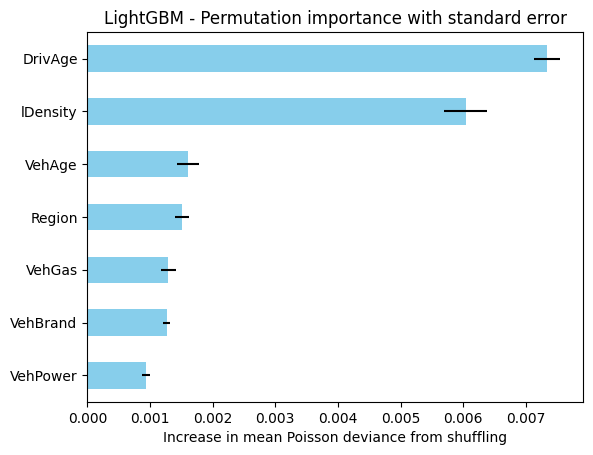

In [12]:
M = 5

for model, label in zip((glm_freq, lgb_freq), ("GLM", "LightGBM")):
    imp = permutation_importance(
        model,
        X=test[features],
        y=test.frequency,
        sample_weight=test.Exposure,
        n_repeats=M,
        random_state=1,
        scoring="neg_mean_poisson_deviance",
        n_jobs=4,
    )

    # Note that variances have been computed using a denominator of M, not M - 1
    df_imp = pd.DataFrame(
        {
            "mean": imp.importances_mean,
            "standard_error": imp.importances_std / np.sqrt(M),
        },
        index=features,
    ).sort_values("mean")

    df_imp["mean"].plot.barh(
        xerr=df_imp["standard_error"],
        xlabel="Increase in mean Poisson deviance from shuffling",
        color="skyblue",
        title=f"{label} - Permutation importance with standard error",
    )
    plt.show()

The possibility to evaluate permutation importance for feature groups is not implemented in Scikit-Learn, but there is an open [pull request](https://github.com/lorentzenchr/model-diagnostics/pull/202) in {model-diagnostics} with this option.

## Effects

In the following section, we are describing feature effects using different techniques. Some of them focus on main effects (PDP, ALE, M plots), while ICE also provides info on interaction effects. The last technique shown in this section is Friedman and Popescu's H statistic to find strong interactions.

### Individual conditional expectations (ICE)

Let's start with ICE plots for the most important feature, `DrivAge`. To focus on interaction strength, we use centered ICE plots on link scale.

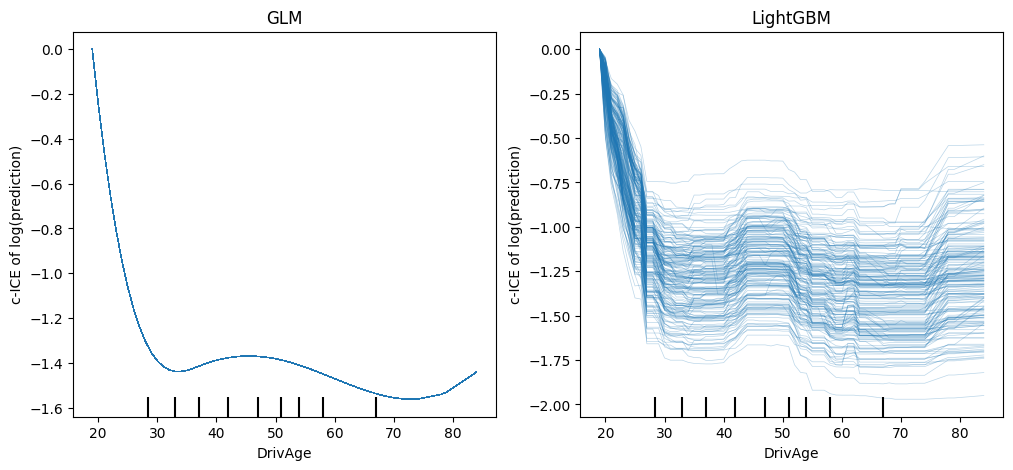

In [13]:
# The methods of sklearn.inspection are picky:
# They require a fitted model sticking to the Scikit-Learn API.
class LogRegressor(RegressorMixin):
    """Predictions on log scale."""

    def __init__(self, estimator):
        self._estimator = estimator
        self.is_fitted_ = True

    def fit(self, *args, **kwargs):
        return self

    def predict(self, X):
        return np.log(self._estimator.predict(X))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for model, label, ax in zip((glm_freq, lgb_freq), ("GLM", "LightGBM"), axes):
    p = PartialDependenceDisplay.from_estimator(
        LogRegressor(model),
        X=learn.sample(200, random_state=42),
        features=["DrivAge"],
        kind="individual",
        ax=ax,
        centered=True,
    )
    ax.set_title(label)
    p.axes_[0, 0].set_ylabel("c-ICE of log(prediction)")


### Partial dependence plots (PDP)

Let's aggregate those wild lines to the well-known PDP. We are focusing on four important features.

Note that we would prefer points instead of bars to represent ICE for categorical features.

In [14]:
some_features = ["DrivAge", "lDensity", "VehAge", "Region"]

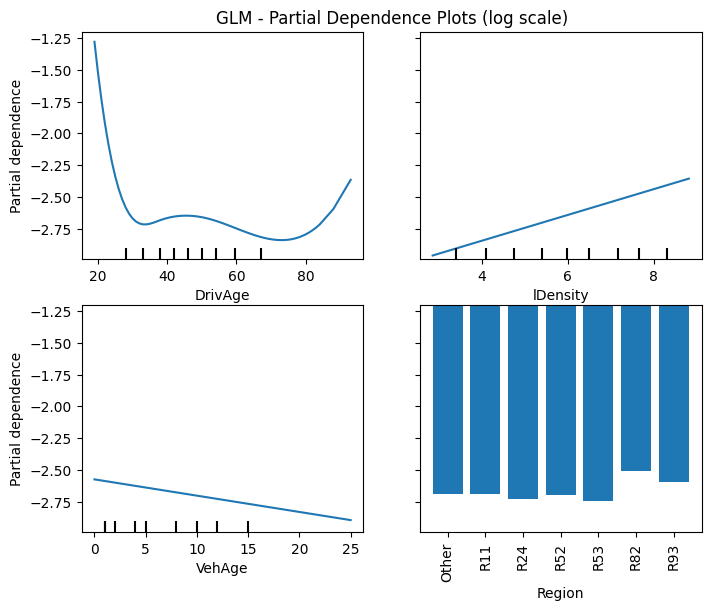

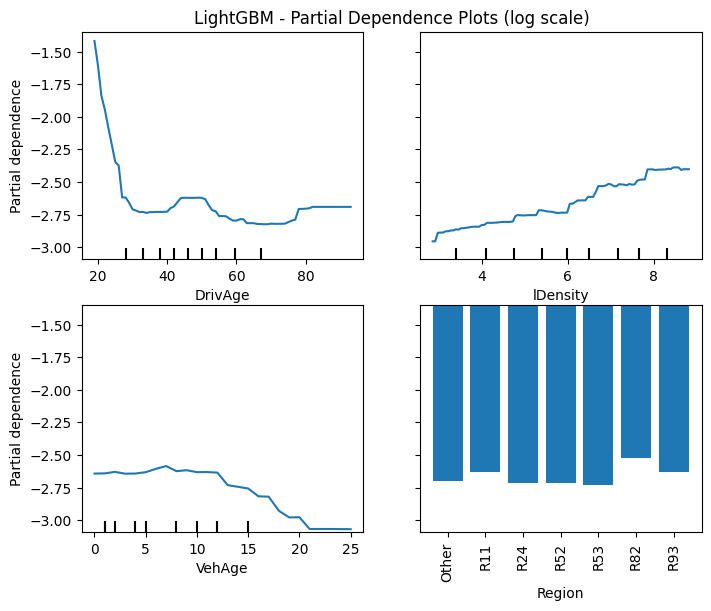

In [15]:
df_explain = learn.sample(1000, random_state=42)

for model, label in zip((glm_freq, lgb_freq), ("GLM", "LightGBM")):
    fig, ax = plt.subplots(figsize=(8, 6.5))

    _ = PartialDependenceDisplay.from_estimator(
        LogRegressor(model),
        X=df_explain[features],
        features=some_features,
        categorical_features=["Region"],
        sample_weight=df_explain.Exposure,
        n_cols=2,
        ax=ax,
    )
    ax.set_title(f"{label} - Partial Dependence Plots (log scale)")

### ALE

Currently neither available in Scikit-Learn nor in model-diagnostics. [Our adaption](https://github.com/mayer79/accumulated_local_effects) (use with care) is roughly based on https://github.com/blent-ai/ALEPython. It only considers the case of one continuous feature, but supports case weights, manual bins, and probabilitic classification. Additionally, standard deviations show local interaction strength. For the GLM, because we predict on link scale, they are all 0.

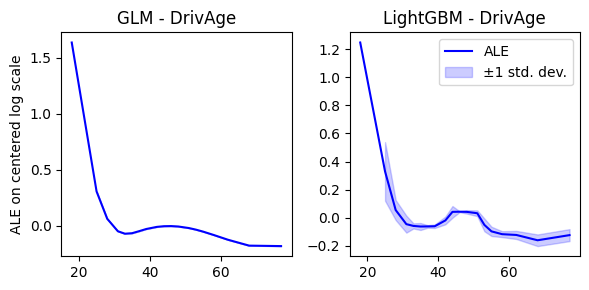

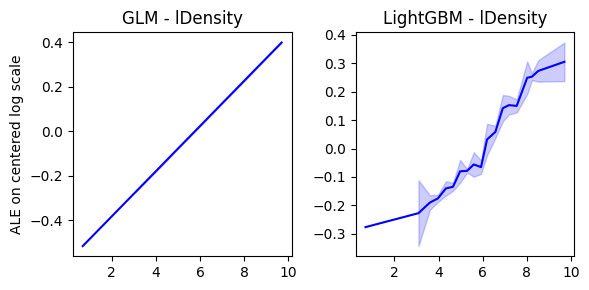

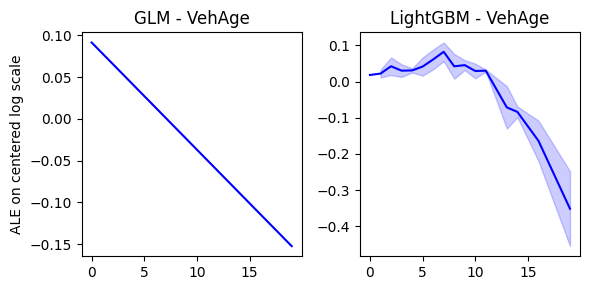

In [16]:
from ale import accumulated_local_effects

# To speed-up things, we don't use the full dataset for ALE (but we could)
df_ale = learn.sample(100_000, random_state=1)

for feature in ["DrivAge", "lDensity", "VehAge"]:
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    for model, label, ax in zip((glm_freq, lgb_freq), ("GLM", "LightGBM"), axes):
        ale = accumulated_local_effects(
            df_ale,
            lambda x: np.log(model.predict(x)),
            feature=feature,
            trim=(0, 0.98),  # trim highest 2% values
            weights=df_ale.Exposure,
        )
        ax.plot(ale["breaks"], ale["ale"], "b-", label="ALE")
        upper, lower = (ale["ale"] + d * ale["standard_deviations"] for d in (1, -1))
        ax.fill_between(
            ale["breaks"], lower, upper, alpha=0.2, color="blue", label="±1 std. dev."
        )
        ax.set_title(f"{label} - {feature}")
        if label == "LightGBM" and feature == "DrivAge":
            ax.legend()
        if label == "GLM":
            ax.set_ylabel("ALE on centered log scale")

    plt.tight_layout()
    plt.show()


### M plot on test data (original scale)

Let's now focus on a very simple, but useful technique: M plots. They plot average predictions against (binned) feature values. Comparison with average observed gives a good impression on bias, over-, and underfitting. Ideally, the plots are computed for both training and test data. We do it on the test data for brevity.

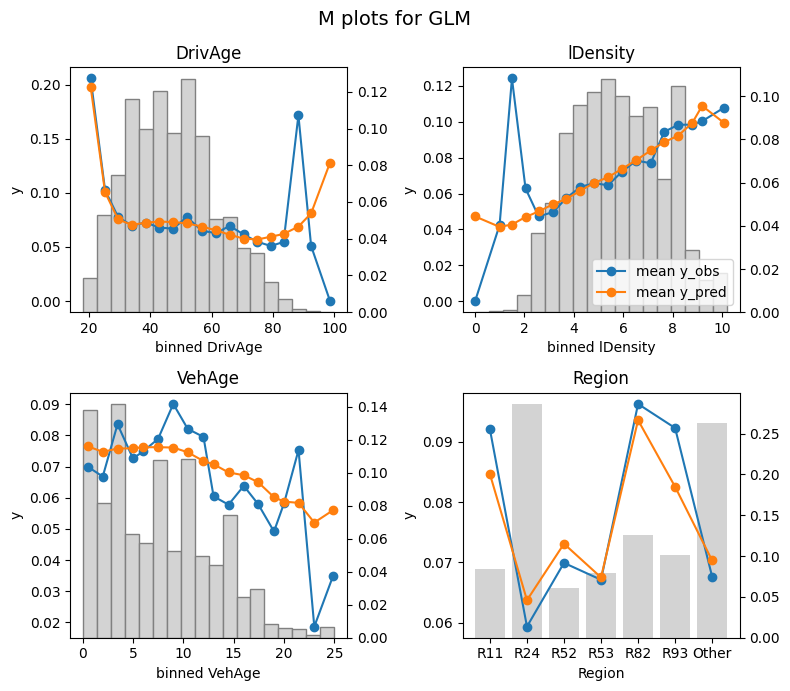

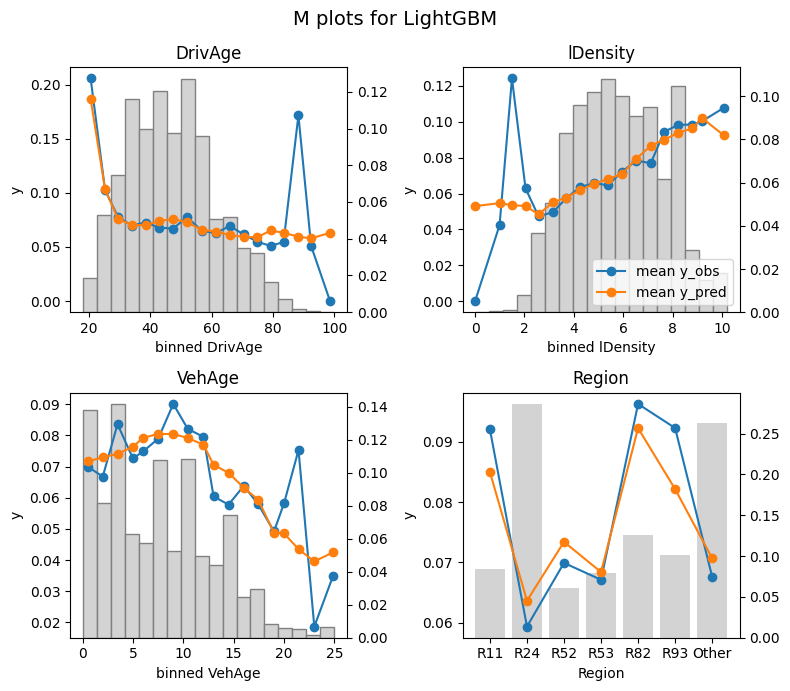

In [17]:
for model, label in zip((glm_freq, lgb_freq), ("GLM", "LightGBM")):
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))

    for i, (feature, ax) in enumerate(zip(some_features, axes.flatten())):
        plot_marginal(
            y_obs=test.frequency,
            y_pred=model.predict(test),
            X=test,
            feature_name=feature,
            weights=test.Exposure,
            show_lines="always",
            ax=ax,
        )
        ax.set_title(feature)
        ax.legend().set_visible(i == 1)
        fig.suptitle(f"M plots for {label}", fontsize=14)
    fig.tight_layout()

### Combine with PDP

Let's combine M plots with partial dependence to see different aspects in one go. Ideally, we could even show ALE for continuous features as well.

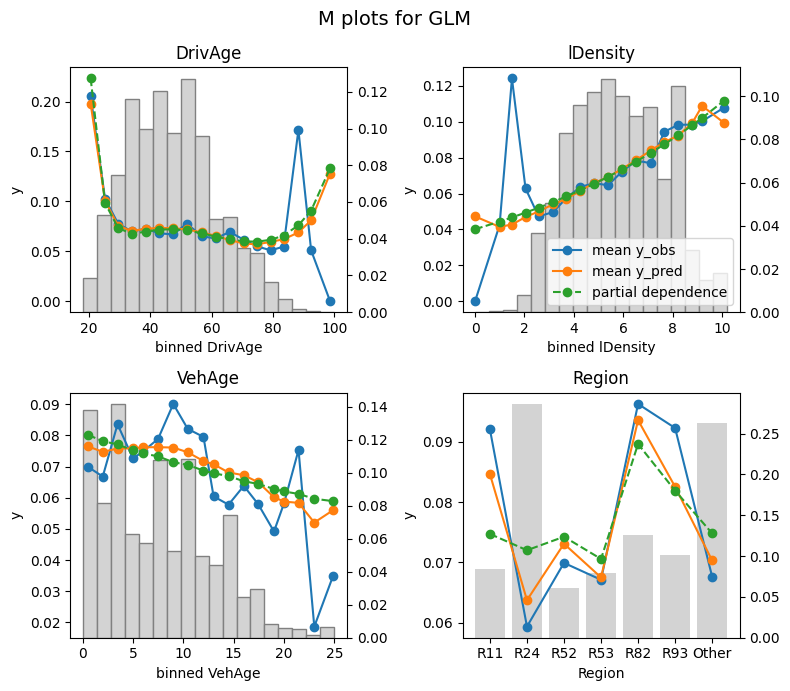

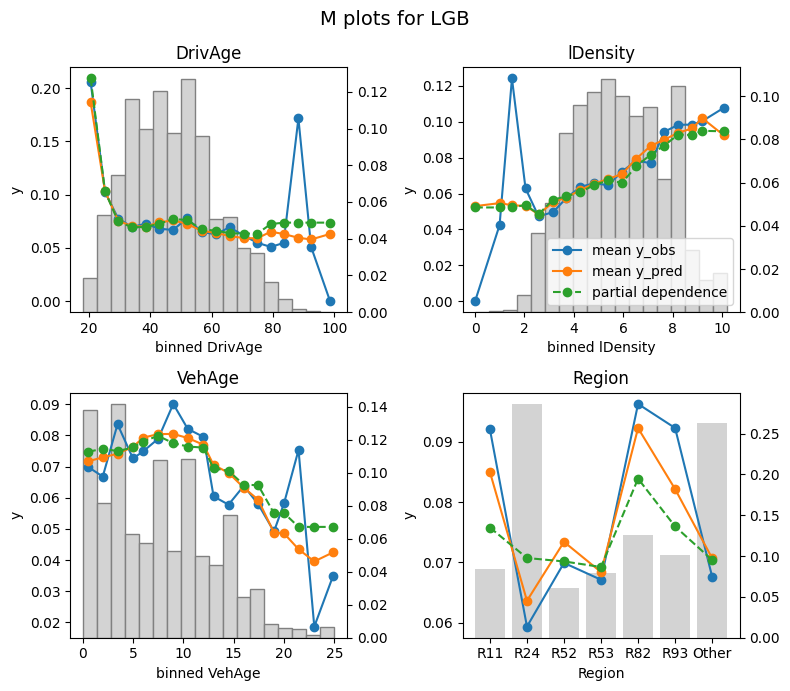

In [18]:
for label, model in zip(("GLM", "LGB"), (glm_freq, lgb_freq)):
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))

    for i, (feature, ax) in enumerate(zip(some_features, axes.flatten())):
        plot_marginal(
            y_obs=test.frequency,
            y_pred=model.predict(test),
            X=test,
            feature_name=feature,
            predict_function=model.predict,
            weights=test.Exposure,
            show_lines="always",
            ax=ax,
        )
        ax.set_title(feature)
        ax.legend().set_visible(i == 1)
        fig.suptitle(f"M plots for {label}", fontsize=14)
    fig.tight_layout()


### Interactions

Let's crunch pairwise H statistics for four important features. We evaluate them on link scale, so that values of a GLM would be constant 0 (not shown). Relative $H^2$ and absolute $H$ are both interesting, so
we show both. We use [this implementation](https://github.com/mayer79/pyhstatistics), which is taken from our pull request [here](scikit-learn/scikit-learn#28375) as per June 2025.

In [19]:
from hstats import h_statistic

H = h_statistic(
    LogRegressor(lgb_freq),
    X=learn,
    features=some_features,
    sample_weight=learn.Exposure,
    random_state=1,
)

H_df = pd.DataFrame(
    {
        "H2": H["h_squared_pairwise"].flatten(),
        "H_unnormalized": np.sqrt(H["numerator_pairwise"]).flatten(),
    },
    index=[str(pair) for pair in H["feature_pairs"]],
)

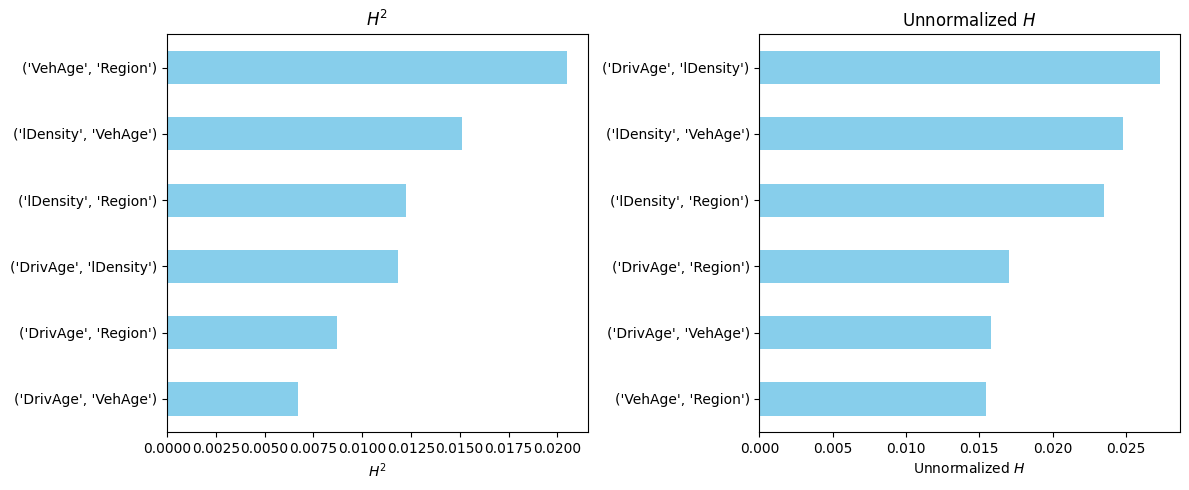

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for col, title, ax in zip(H_df.columns, ("$H^2$", "Unnormalized $H$"), axes):
    H_df[col].sort_values().plot.barh(
        ax=ax,
        title=f"{title}",
        xlabel=f"{title}",
        color="skyblue",
    )
plt.tight_layout()

All interactions are very weak, and might even mainly be the result of overfitting, explaining why the LightGBM model in this example does not have better performance than the GLM. Let's still visualize a pairwise interaction as 2D PDP (other visualizations require more coding). Note that, in Scikit-Learn <= 1.6, 2D PDPs are only supported for numeric features.

Text(0.5, 0.98, 'LGB - 2D PDP (log scale)')

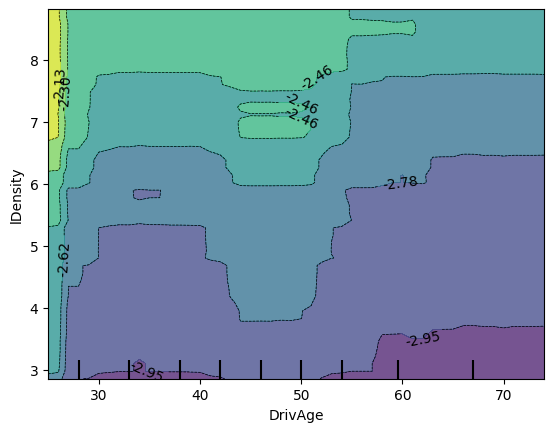

In [21]:
PartialDependenceDisplay.from_estimator(
    LogRegressor(model),
    X=df_explain[features],
    features=[("DrivAge", "lDensity")],
    sample_weight=df_explain.Exposure,
    grid_resolution=50,
)
fig.suptitle("LGB - 2D PDP (log scale)", fontsize=14)


## Global surrogate models

Approximate predictions of a black box model (here: LightGBM) by a 
short decision tree to give a rough explanation of the black box.
The R-squared of this surrogate model quantifies how well the approximation works.

R^2 (approximation quality): 0.635


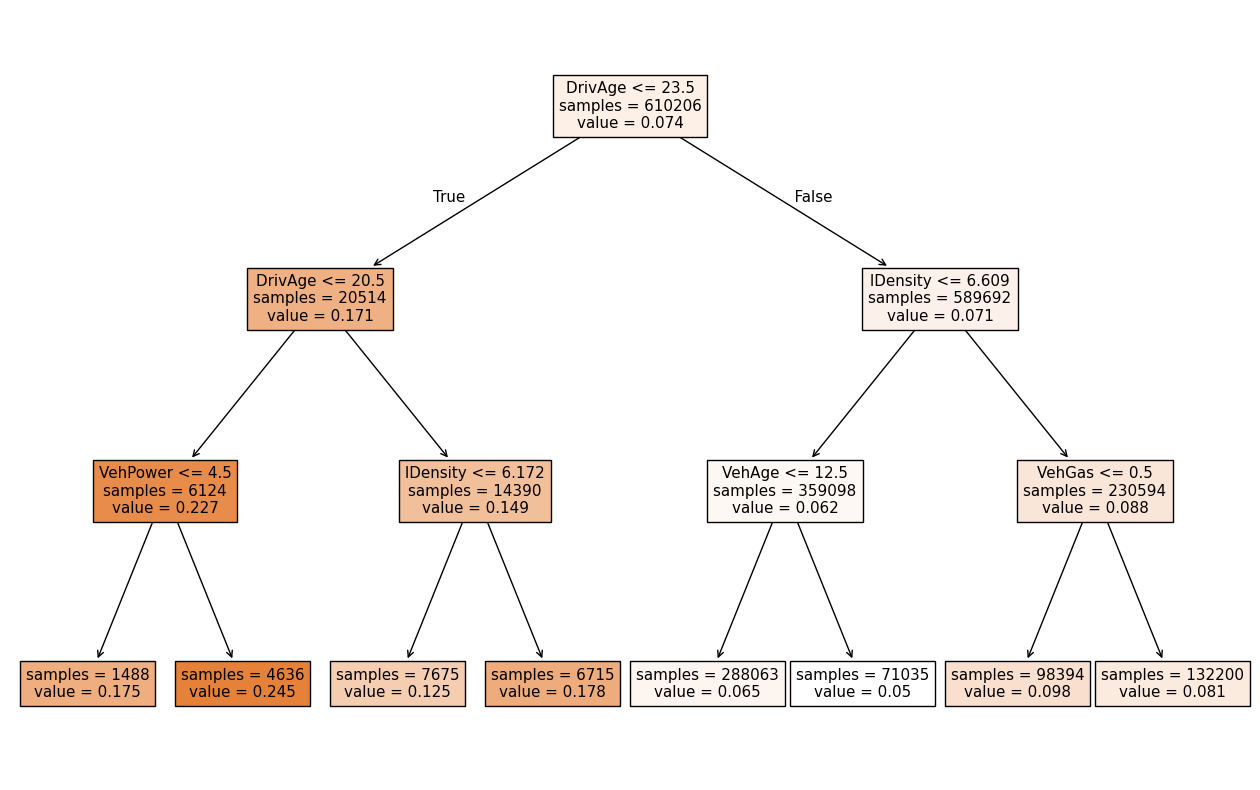

In [22]:
# Code adapted from Chapter 6
lgb_freq_pred = lgb_freq.predict(learn)

# Plotting requires the features to be numeric
# Thus, we materialize the preprocessed data
X_learn = preprocess_tree.fit_transform(learn)

surrogate_tree = DecisionTreeRegressor(max_depth=3)
surrogate_tree.fit(X_learn, y=lgb_freq_pred, sample_weight=learn.Exposure)

plt.figure(figsize=(16, 10))
_ = tree.plot_tree(
    surrogate_tree, feature_names=X_learn.columns, filled=True, impurity=False
)

r_squared = surrogate_tree.score(X_learn, y=lgb_freq_pred, sample_weight=learn.Exposure)
print(f"R^2 (approximation quality): {r_squared:.3f}")


## SHAP

We use TreeSHAP to decompose 2000 predictions into contributions of the features.
The implementation in LightGBM provides the decomposition in log link space for Poisson and Gamma loss.

In [23]:
# We need to separate the preprocessing from the model for TreeSHAP calculations
X_display = learn.sample(2000, random_state=1)  # , weights=learn["Exposure"]
X_explain = preprocess_tree.transform(X_display)

explainer_lgb_freq = shap.Explainer(lgb_freq[-1])
shap_lgb_freq = explainer_lgb_freq(X_explain)

# Trick to show original categories of categorical features in some plots
shap_lgb_freq.display_data = X_display[X_explain.columns]

### Illustration

Decomposition of one prediction.

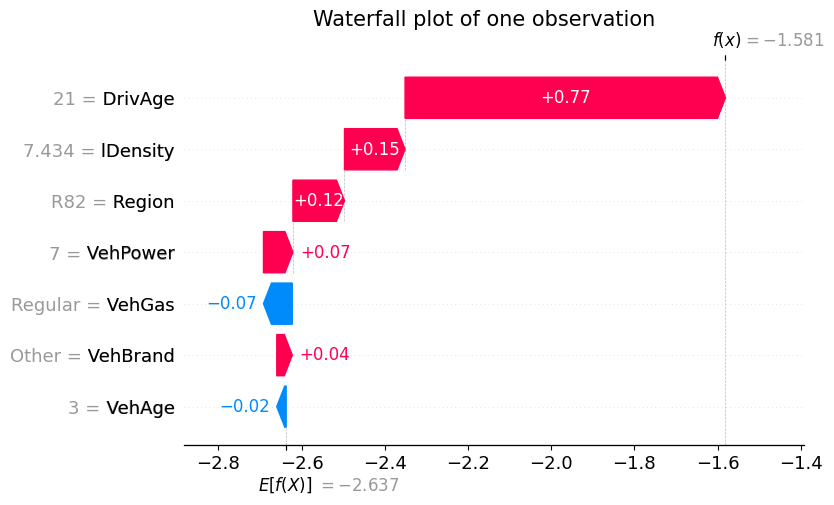

In [24]:
plt.suptitle("Waterfall plot of one observation", fontsize=15)
shap.plots.waterfall(shap_lgb_freq[0])

### SHAP importance

Average absolute SHAP values per feature over all 2000 observations.

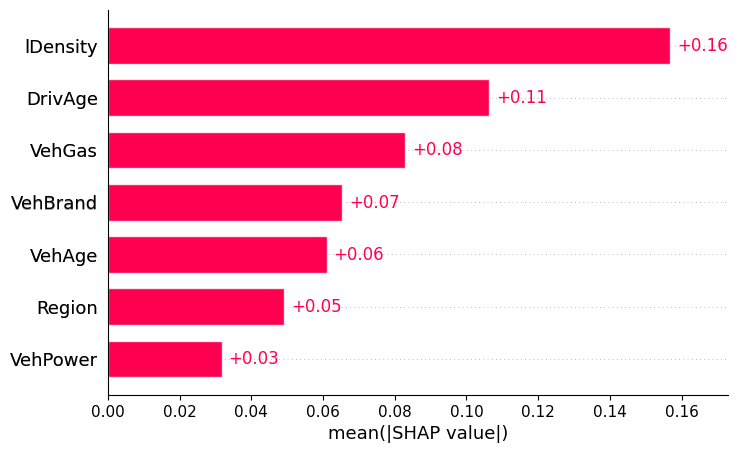

In [25]:
shap.plots.bar(shap_lgb_freq)

### Beeswarm "summary" plots

Univariate distribution of SHAP values.

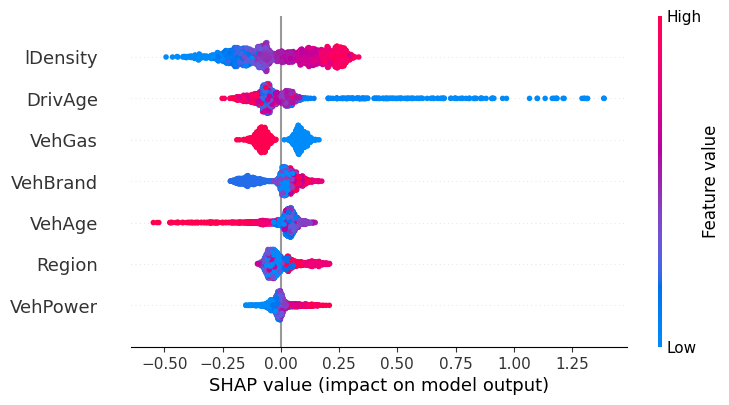

In [26]:
shap.plots.beeswarm(shap_lgb_freq)

### SHAP dependence

The color variable is selected by a variance-based interaction heuristic.

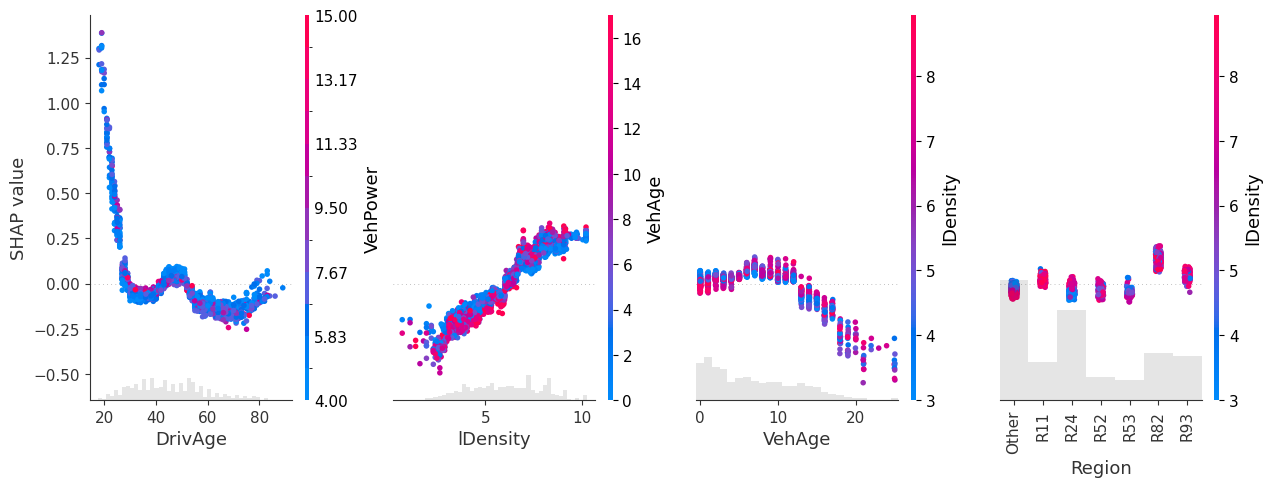

In [ ]:
shap.plots.scatter(shap_lgb_freq[:, some_features], color=shap_lgb_freq)

### Permutation SHAP for the LightGBM model (slow)

To show how neural nets, GLMs etc. could be handled by a model-agnostic method, we also calculate permutation SHAP.
A complication is that X_explain must be numerically encoded. This is a nightmare with "1 to many" preprocessors such as 
one-hot-encoding and splines.

In [ ]:
if False:
    # Since p is small, we use the exact version of shap.explainers.Permutation
    explainer_lgb_freq_perm = shap.explainers.Exact(
        lambda x: np.log(lgb_freq[-1].predict(x)),
        X_explain.head(200),  # Background dataset for permutation SHAP
    )

    # 1.5 minutes
    shap_lgb_freq_perm = explainer_lgb_freq_perm(X_explain, max_evals=300)

ExactExplainer explainer: 2001it [01:26, 21.12it/s]                          


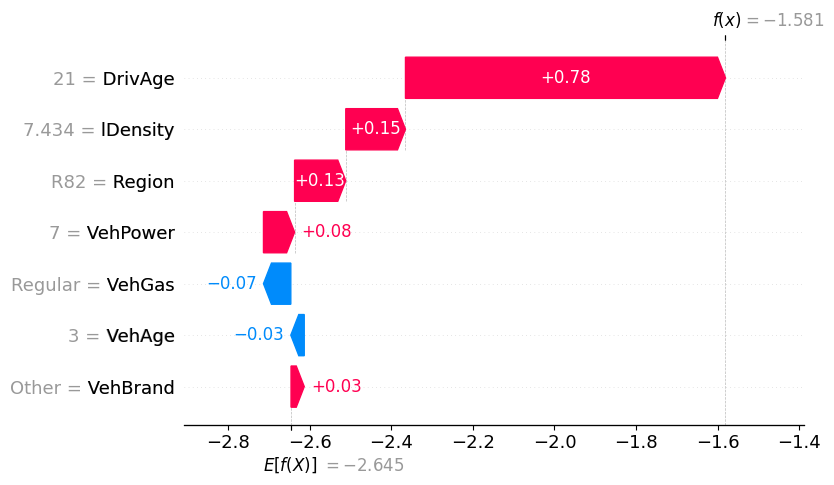

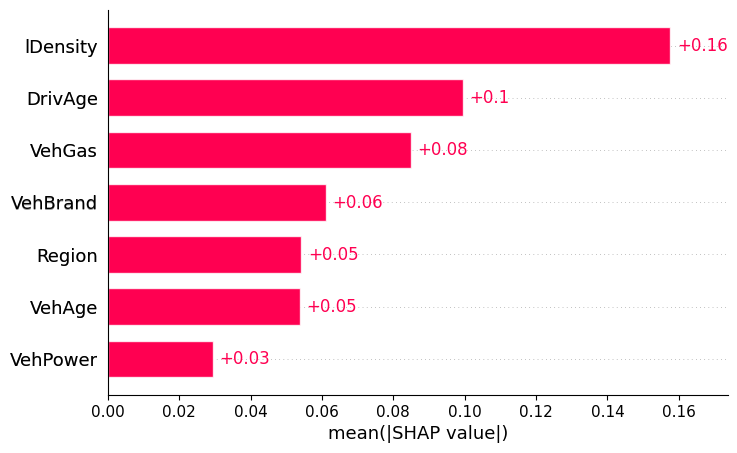

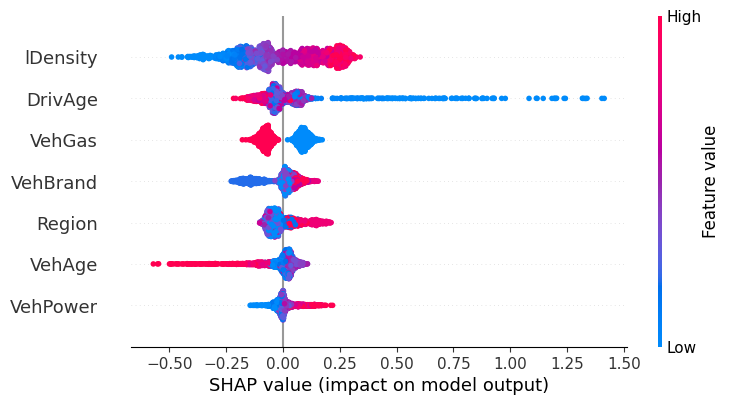

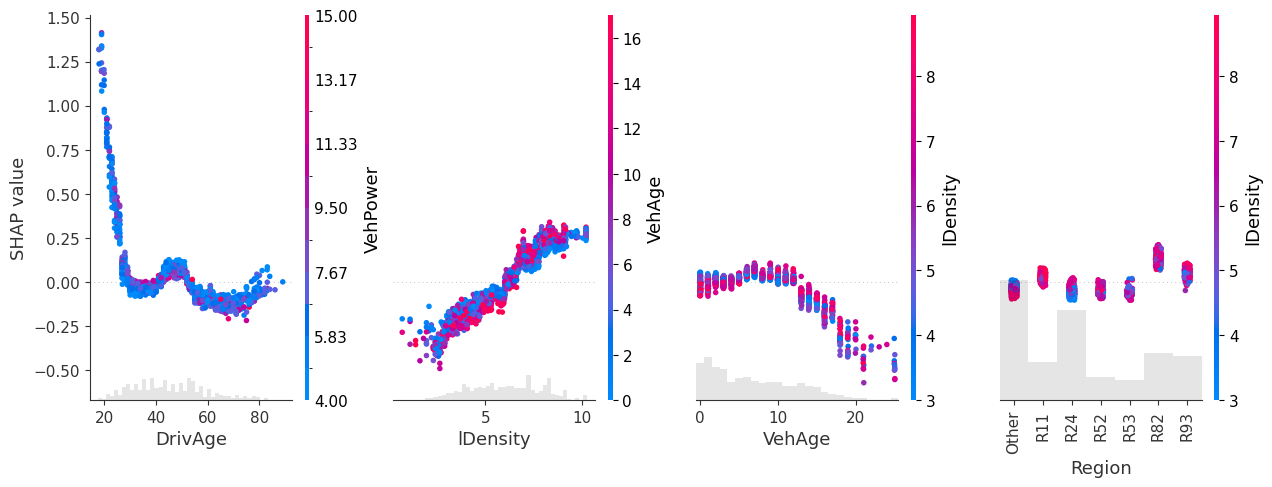

In [ ]:
if False:
    shap_lgb_freq_perm.display_data = X_display[X_explain.columns]  # Trick
    shap.plots.waterfall(shap_lgb_freq_perm[0])  # First observation
    shap.plots.bar(shap_lgb_freq_perm)
    shap.plots.beeswarm(shap_lgb_freq_perm)
    shap.plots.scatter(shap_lgb_freq_perm[:, some_features], color=shap_lgb_freq_perm)

### Severity model to build combined pure premium model

How can we use TreeSHAP to explain a freq-sev pure premium model instead of falling back to a slow model-agnostic method?

-> Apply TreeSHAP to severity model and then use linearity/additivity of SHAP. Let's start with the severity model.

In [31]:
learn_sev = learn[learn.ClaimNb > 0]

In [32]:
# Parameters again found by randomized search CV (tuning not shown)
params_sev = {
    "objective": "gamma",  # gamma distribution
    "learning_rate": 0.01,
    "num_leaves": 2,  # additive model on log link scale
    "reg_lambda": 7.5,
    "reg_alpha": 2.5,
    "colsample_bynode": 0.8,
    "subsample": 1,
    "min_child_samples": 50,
    "min_split_gain": 0.1,
}
nrounds_sev = 426

lgb_sev_raw = LGBMRegressor(
    **params_sev, n_estimators=nrounds_sev, importance_type="gain", random_state=5
)
lgb_sev = Pipeline([("preprocessor", preprocess_tree), ("model", lgb_sev_raw)])
lgb_sev.fit(
    X=learn_sev,
    y=learn_sev.severity,
    model__sample_weight=learn_sev.ClaimNb,
    model__categorical_feature=unordered,
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 22434, number of used features: 7
[LightGBM] [Info] Start training from score 7.490949


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['DrivAge', 'lDensity',
                                                   'VehAge', 'VehPower']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['Region', 'VehBrand',
                                                   'VehGas'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LGBMRegressor(colsample_bynode=0.8, importance_type='gain',
                               learning_rate=0.01, min_child_samples=50,
                               min_split_gain=0.1, n_estimators=426,
                               num_leaves=2, objective='gamma', random_state=5,
                               reg_alpha=2.5, reg_lambda=7.5, subsample=1))])

### Pure risk premium model

Now, we sum up the SHAP values (on log link scale) from the frequency and severity models to get SHAP values for the combined pure premium model. 
In case the features would not match 1:1, some additional code would be required.

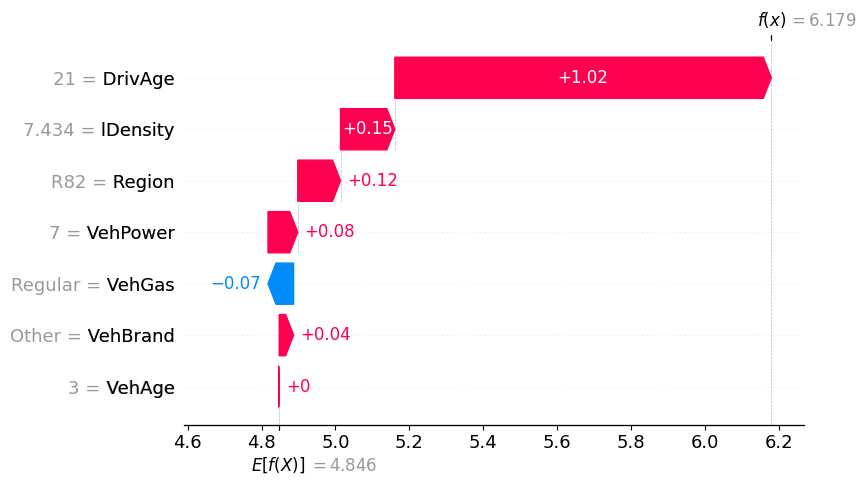

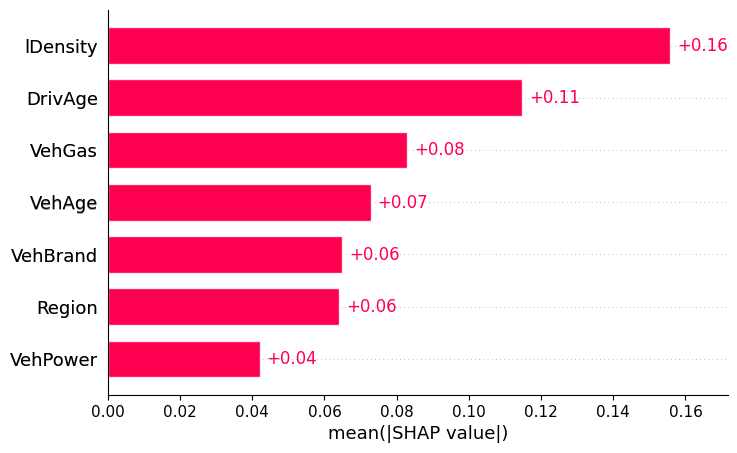

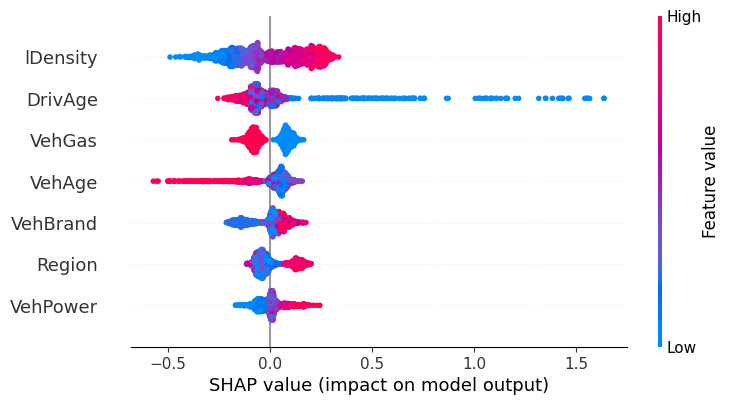

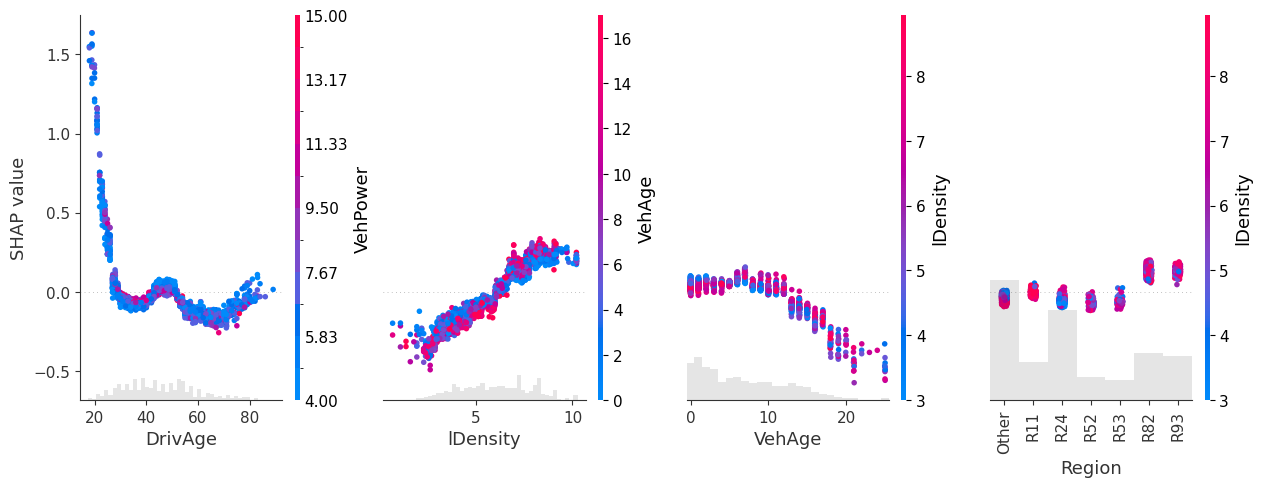

In [33]:
# Calculate SHAP for the severity model on the same data as for the frequency model
explainer_lgb_sev = shap.Explainer(lgb_sev_raw)
shap_lgb_sev = explainer_lgb_sev(X_explain)

# Combine with frequency model SHAP values
shap_pp = shap.Explanation(
    values=shap_lgb_freq.values + shap_lgb_sev.values,  # noqa: PD011
    base_values=shap_lgb_freq.base_values + shap_lgb_sev.base_values,
    data=shap_lgb_freq.data,
    display_data=shap_lgb_freq.display_data,
    feature_names=shap_lgb_freq.feature_names,
)

# SHAP analysis of the pure risk premium model on log link scale
shap.plots.waterfall(shap_pp[0])  # First observation
shap.plots.bar(shap_pp)
shap.plots.beeswarm(shap_pp)
shap.plots.scatter(shap_pp[:, some_features], color=shap_pp)